## Configuration and Utility functions

In [1]:
import numpy
import os
import glob
import random
import pandas
import math 
import pprint

# My Utility Scripts
from printd import printd
from plots import plot_curves
from plots import plot_boxes

# Model Methods
import sklearn.metrics
import sklearn.preprocessing

import sklearn.model_selection
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

import sklearn.kernel_ridge
from sklearn.kernel_ridge import KernelRidge

import kernel_ridge_regression
from kernel_ridge_regression import kernel_ridge_param_search
from kernel_ridge_regression import kernel_ridge_cv
from kernel_ridge_regression import krr_private_param_rand_search
from kernel_ridge_regression import krr_private_cross_validate

# Differential Privacy Methods
import differential_privacy_mechanisms_update 
from differential_privacy_mechanisms_update import gaussian_mechanism
from differential_privacy_mechanisms_update import gaussian_mechanism_sample
from differential_privacy_mechanisms_update import MVGMechanism
from differential_privacy_mechanisms_update import mvg_mechanism_sample


import matplotlib
import matplotlib.pyplot as plot

# Put the graphs where we can see them
%matplotlib inline

# Set seed for reproducability
random.seed(122018)

## Load Experiment Data

Each experiment and the data used is as described in:

        'A Differential Privacy Mechanism Design Under Matrix-Valued Query'
        Chanyaswad, Dytso, Poor & Mittal 2018:
        https://arxiv.org/abs/1802.10077 (accessed 16/12/2018) [1]

In [2]:
path_data = 'data/'

# Import Experiment 1 dataset
dataset_1 = path_data + 'liver_disorders/liver_disorders.data'

# Dictionary to hold all details of experiment 1
e1 = dict()
e1['data raw'] = numpy.genfromtxt(dataset_1, delimiter=',')[:,:6]
e1['data labels'] = ['mcv','alkphos','sgpt','sgot','gammagt','drinks']
e1['data label descriptions'] = [
    'mean corpuscular volume',
    'alkaline phosphotase',
    'alamine aminotransferase',
    'aspartate aminotransferase',
    'gamma-glutamyl transpeptidase',
    'number of half-pint equivalents of alcoholic beverages drunk per day'
]

In [36]:
# Helper functions
def centre_and_scale_data(data, scale):
    ''' 
        Data preprocessing step of:
            Centering - subtract mean of feature 
            Scaling data - tranforming data retaining proportion such that maximum and minimum 
                values are as specified ie values scaled to randge [-1,1]
    ''' 
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(scale[0], scale[1]),
                                                copy=True)
    return scaler.fit_transform(data - numpy.mean(data, axis=0))

def root_mean_squared_error(y_true, y_pred):
    '''
    Computation of evaluation metric RMSE
    '''
    return pow(sklearn.metrics.mean_squared_error(y_true, y_pred)/ len(y_true), 0.5)


def rmse_scorer():
    '''
    Wrapper function to create sklearn 'scorer' for RMSE metric
    '''
    return sklearn.metrics.make_scorer(root_mean_squared_error, 
                                       greater_is_better=False)

def print_aggregate_result(model_name, n_samples, results, aggregate_function):
    '''
    Helper function to print aggregate result for experiment model 
    '''
    printd('{n} {function} RMSE of {s} samples {rmse}', 
           n=model_name,
           s=n_samples, 
           function=aggregate_function.__name__,
           rmse=aggregate_function(results))
    

def plot_singleton_features_vs_teacher(X, y, model, data_labels, plot_title):
    '''
    Display singleton features vs teacher 
        Overlay of naive projection of kernel ridge regression line of best fit 
    '''
    e1_x_plot = numpy.array([ numpy.linspace(-1,1,100) 
                             for _ in range(X.shape[1])]).transpose()

    model.fit(X, y)
    predict_y = model.predict(e1_x_plot)

    plot.suptitle(plot_title)
    for i in range(5):
        plot.subplot(231+i)
        plot.scatter(X[:,i], y, s=5)
        plot.xlabel(data_labels[i])
        if i in [0,3]:
            plot.ylabel(data_labels[5])

        plot.scatter(e1_x_plot[:,i], predict_y, c='r', s=5)

    plot.subplots_adjust(top=0.80, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                        wspace=0.4)
    
    
def bootstrap_metric(data, metric_function, alpha, repetitions, samples=None, result_precision=5):
    '''
        Calcuate metric with the following algorithm:
            1. Take n='repetitions' samples from 'data' with replacement of size 'samples'
            2. Calculate metric for each sample and sort
            3. Calculate and return lower and upper quartile of sample metrics
            
    '''     
    if samples == None:
        samples = len(data)
    
    bootstrap_set = sorted([ metric_function(numpy.random.choice(data, samples)) for _ in xrange(repetitions)])
    lower_quantile = int(repetitions*(alpha/2))
    upper_quantile = int(repetitions*(1-(alpha/2)))
  
    return numpy.round((
        bootstrap_set[lower_quantile], 
        bootstrap_set[upper_quantile]
    ), result_precision)

## Experiment 1

Experiment 1 setup as described in [1] section 8.1, page/s 29-30.
This experiment aims to compare data utility preservation after application of ($\epsilon$,$\delta$)-differentially private basic random mechanisms. 

The following cases will be compared for utility properites using a kernel ridge regression (KRR) model and metric root mean squared error (RMSE):
    1. Non Differentially Private data.
    2. Matrix Variate Guassian using binary allocation strategy using 
       0.55, 0.65, 0.75, 0.85 and 0.95 allocated evenly to 'important' features and the
       remaining % allocated evenly amongst the remaining features.
    3. Matrix Variate Guassian using max-PNR allocation strategy.

In [4]:
# Preprocessing
e1['data processed'] = centre_and_scale_data(data=e1['data raw'], scale=(-1,1))

# Partition feature and teacher values
e1['data'] = dict(X=e1['data processed'][:,:5], y=e1['data processed'][:,5])

In [5]:
# Experiment 1 parameters
# Set Radial basis function as reasonable 'Default' Kernel
# Note: not optimised for kernel function
krr_kernel = 'rbf'
e1_cv_folds = 5
e1_samples = 100

# Differential privacy parameters
e1_epsilon = 1
e1_delta = 1.0 / pow(len(e1['data']['y']), 2)

In [6]:
# %%timeit
# Experiment 1 non private 
# Kernel Ridge Regression model evaluated on un-privatised data set
e1_nondp_params = kernel_ridge_param_search(
    scoring=rmse_scorer(),
    kernel=krr_kernel, 
    cv_folds=e1_cv_folds,
    random=True,
    **e1['data'])

# Combine params and data to pass as single dict
e1_nondp_params.update(e1['data'])

e1['non private'] = kernel_ridge_cv(
    cv_folds=e1_cv_folds,
    kernel=krr_kernel, 
    scoring=rmse_scorer(),
    **e1_nondp_params)

print_aggregate_result(model_name='Non privatised data', 
                       n_samples=1, 
                       results=e1['non private'], 
                       aggregate_function=numpy.median)

'Non privatised data median RMSE of 1 samples 0.0396765690511'


In [38]:
# %%timeit
# Experiment 1 random model 
e1_random_y = numpy.array([
    numpy.array([ random.uniform(-1,1) for _ in range(int(len(e1['data']['y'])/e1_cv_folds))]) 
    for _ in range(e1_cv_folds)
    for _ in range(e1_samples)])

# Since RMSE uses / sqrt(N) if we evaluate entire data set 
# N=345 rather than 5*N=69 we cannot compare RMSE to other models
eval_random_y = numpy.array([ e1['data']['y'][f*len(e1['data']['y'])/e1_cv_folds:((f+1)*len(e1['data']['y'])/e1_cv_folds)] 
                 for f in range(e1_cv_folds) ])

e1['random'] = [
    root_mean_squared_error(
        y_true=eval_random_y[i%5], 
        y_pred=e1_random_y[i])
    for i in range(len(e1_random_y))]

print_aggregate_result(model_name='Random guess', 
                       n_samples=e1_samples, 
                       results=e1['random'], 
                       aggregate_function=numpy.median)

'Random guess median RMSE of 100 samples 0.107856117341'


In [30]:
for f in range(e1_cv_folds):
    print(f*len(e1['data']['y'])/e1_cv_folds,((f+1)*len(e1['data']['y'])/e1_cv_folds)-1)

(0, 68)
(69, 137)
(138, 206)
(207, 275)
(276, 344)


In [8]:
def evaluate_dp_mechanism_krr_cv(data,
                                 samples,
                                 krr_kernel,
                                 scoring_function,
                                 privacy_mechanism_sampler,
                                 mechanism_args):
    '''
    evaluate_dp_mechanism_krr_cv
    
    Evaluates differentially private mechanism by fitting a Kernel Ridge Regression (KRR) model
    returning its cross validation score (using the supplied scoring function)
    
        - Generates differentially private sample from supplied privacy mechanism
        - Tune for lowest score KRR hyperparameters
        - Return cross validation scores for model fit with tuned hyperparameters
    '''
    from sklearn.kernel_ridge import KernelRidge
    
    result = numpy.empty(e1_samples)
    
    test_X = data[:,:-1]
    test_y = data[:,-1]
    
    for i in xrange(e1_samples):
    
        mechanism_sample = privacy_mechanism_sampler(
            data=data,
            **mechanism_args)
        
        parameters = krr_private_param_rand_search(
            train_X=mechanism_sample['X'],
            train_y=mechanism_sample['y'],
            test_X=test_X,
            test_y=test_y,
            rand_iters=100,
            krr_kernel=krr_kernel,
            scoring_function=scoring_function)
        
        model = KernelRidge(kernel=krr_kernel, 
                            alpha=parameters['best_alpha'], 
                            gamma=parameters['best_gamma'])

        return krr_private_cross_validate(
            train_X=mechanism_sample['X'],
            train_y=mechanism_sample['y'],
            test_X=test_X,
            test_y=test_y,
            krr=model,
            score_summary_function=numpy.mean,
            scoring_function=scoring_function)

In [9]:
# %%timeit
# Experiment 1 Gaussian Mechanism
gaussian_mech_args = dict(epsilon=e1_epsilon, 
                          delta=e1_delta,
                          sensitivity=4)

e1['gaussian mechanism'] = [
    evaluate_dp_mechanism_krr_cv(
        data=e1['data processed'],
        samples=e1_samples,
        krr_kernel=krr_kernel,
        scoring_function=root_mean_squared_error,
        privacy_mechanism_sampler=gaussian_mechanism_sample,
        mechanism_args=gaussian_mech_args)
    for _ in xrange(e1_samples)
]

print_aggregate_result(model_name='Guassian Mechanism', 
                       n_samples=e1_samples, 
                       results=e1['gaussian mechanism'], 
                       aggregate_function=numpy.median)

In [12]:
# Experiment 1 MVG Mechanism setup
# Frobenius norm of supremum(f(X)) for f(X) = X in (-1,1)
norm_of_bounding_matrix = numpy.linalg.norm(
    numpy.ones(e1['data processed'].shape, dtype=int)
)

mechanism_args = dict()
e1_mvg_sensitivity = pow(24,0.5)

In [13]:
# %%timeit
# Experiment 1 MVG Mechanism - Binary Allocation Strategy
# Apply Matrix Valued Gaussian sample to un-privatised data

# Precision allocation is binary allocation strategy (using domain knowledge)
# Discussed in Section 7 p26 and Section 8.1.3 p30
important_feature_allocations = [0.55, 0.65, 0.75, 0.85, 0.95]
precision_allocations = [
    (numpy.round([
        (1-fa)/4, 
        (1-fa)/4, 
        fa/2, 
        (1-fa)/4, 
        (1-fa)/4, 
        fa/2],5), 
    fa)
    for fa in important_feature_allocations
]

for allocation, fa in precision_allocations:
    
    key = 'mvg binary '+str(fa)
    
    mechanism_args[key] = dict(
            epsilon=e1_epsilon,
            delta=e1_delta,
            sensitivity=e1_mvg_sensitivity,
            query_sup=norm_of_bounding_matrix,
            covariance_direction='unimodal features',
            precision=allocation,
            precision_direction=numpy.identity(e1['data processed'].shape[1]))
    
    e1[key] = [
        evaluate_dp_mechanism_krr_cv(
            data=e1['data processed'],
            samples=e1_samples,
            krr_kernel=krr_kernel,
            scoring_function=root_mean_squared_error,
            privacy_mechanism_sampler=mvg_mechanism_sample,
            mechanism_args=mechanism_args[key])
        for _ in xrange(e1_samples)
    ]

In [14]:
# %%timeit
# Experiment 1 MVG Mechanism - PCA Allocation Strategy
# Apply Matrix Valued Gaussian sample to un-privatised data
components, singular_values, _ = numpy.linalg.svd(
    numpy.matmul(numpy.transpose(e1['data processed']), e1['data processed']), 
    full_matrices=True)

singular_ratios = singular_values / numpy.sum(singular_values)

important_feature_allocations = [0.55, 0.65, 0.75, 0.85, 0.95]
precision_allocations_pca = [
    ((1-fa)/len(singular_values) 
        + fa*singular_ratios, 
    fa)
    for fa in important_feature_allocations]

for allocation, fa in precision_allocations_pca:
    
    key = 'mvg pca '+str(fa)
    
    mechanism_args[key] = dict(
            epsilon=e1_epsilon,
            delta=e1_delta,
            sensitivity=e1_mvg_sensitivity,
            query_sup=norm_of_bounding_matrix,
            covariance_direction='unimodal features',
            precision=allocation,
            precision_direction=components) 
    
    e1[key] = [
        evaluate_dp_mechanism_krr_cv(
            data=e1['data processed'],
            samples=e1_samples,
            krr_kernel=krr_kernel,
            scoring_function=root_mean_squared_error,
            privacy_mechanism_sampler=mvg_mechanism_sample,
            mechanism_args=mechanism_args[key])
        for _ in xrange(e1_samples)
    ]

differential_privacy_mechanisms_update.py:281: RuntimeWarning: covariance is not positive-semidefinite.
  cov=self.covariance['kron_product']


## Plots

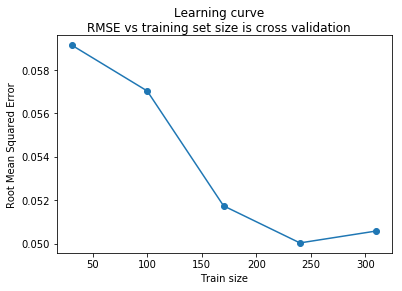

In [15]:
# Plot learning curve for Kernel Ridge Regression fit to non differentially private data 
model_KRR = KernelRidge(kernel=krr_kernel,
                        alpha=e1_nondp_params['alpha'], 
                        gamma=e1_nondp_params['gamma'])

train_sizes, train_scores, test_scores = \
    learning_curve(model_KRR, 
                   e1['data']['X'],
                   e1['data']['y'],
                   scoring=rmse_scorer(),
                   cv=10)

plot.suptitle('Learning curve\nRMSE vs training set size is cross validation')  
plot.plot(train_sizes, -test_scores.mean(1), 'o-')
plot.xlabel("Train size")
plot.ylabel("Root Mean Squared Error")
plot.show()

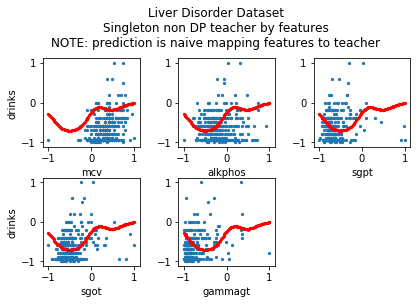

In [16]:
# Plots of Non Differentially Private data and simple regression projection
krr_non_dp_model = KernelRidge(kernel=krr_kernel, 
                               alpha=e1_nondp_params['alpha'], 
                               gamma=e1_nondp_params['gamma'])

plot_singleton_features_vs_teacher(
    X=e1['data']['X'],
    y=e1['data']['y'],
    model=krr_non_dp_model,
    data_labels=e1['data labels'],
    plot_title='Liver Disorder Dataset\nSingleton non DP teacher by features\nNOTE: prediction is naive mapping features to teacher')

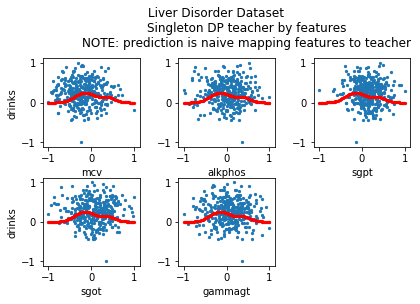

In [17]:
# Plots of Gaussian sample data and simple regression projection
gaussian_mech_args = dict(epsilon=e1_epsilon, 
                          delta=e1_delta,
                          sensitivity=4)
  
mechanism_sample = gaussian_mechanism_sample(
    data=e1['data processed'],
    **gaussian_mech_args)
    
parameters = krr_private_param_rand_search(
    train_X=mechanism_sample['X'],
    train_y=mechanism_sample['y'],
    test_X=e1['data processed'][:,:-1],
    test_y=e1['data processed'][:,-1],
    rand_iters=100,
    krr_kernel=krr_kernel,
    scoring_function=root_mean_squared_error)

krr_gaussian_dp_model = KernelRidge(kernel=krr_kernel, 
                                    alpha=parameters['best_alpha'], 
                                    gamma=parameters['best_gamma'])

plot_singleton_features_vs_teacher(
    X=mechanism_sample['X'],
    y=mechanism_sample['y'],
    model=krr_gaussian_dp_model,
    data_labels=e1['data labels'],
    plot_title='Liver Disorder Dataset\n\
                Singleton DP teacher by features\n\
                NOTE: prediction is naive mapping features to teacher')

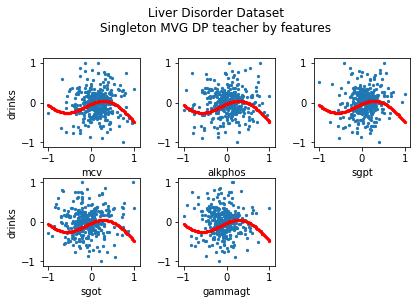

In [18]:
# Plots of MVG sample data and simple regression projection
important_feature_allocations = [0.55, 0.65, 0.75, 0.85, 0.95]
precision_allocations = [
    (numpy.round([
        (1-fa)/4, 
        (1-fa)/4, 
        fa/2, 
        (1-fa)/4, 
        (1-fa)/4, 
        fa/2],5), 
    fa)
    for fa in important_feature_allocations
]

mechanism_sample = mvg_mechanism_sample(
    data=e1['data processed'],
    epsilon=e1_epsilon,
    delta=e1_delta,
    sensitivity=e1_mvg_sensitivity,
    query_sup=norm_of_bounding_matrix,
    precision=precision_allocations[-1][0],
    precision_direction=numpy.identity(e1['data processed'].shape[1]))


parameters = krr_private_param_rand_search(
    train_X=mechanism_sample['X'],
    train_y=mechanism_sample['y'],
    test_X=e1['data processed'][:,:-1],
    test_y=e1['data processed'][:,-1],
    rand_iters=1000,
    krr_kernel=krr_kernel,
    scoring_function=root_mean_squared_error)

krr_mvg_dp_model = KernelRidge(kernel=krr_kernel, 
                               alpha=parameters['best_alpha'], 
                               gamma=parameters['best_gamma'])

plot_singleton_features_vs_teacher(
    X=mechanism_sample['X'],
    y=mechanism_sample['y'],
    model=krr_mvg_dp_model,
    data_labels=e1['data labels'],
    plot_title='Liver Disorder Dataset\nSingleton MVG DP teacher by features')

In [39]:
# Prepare data sets to display experimental results
exempt = ['data labels','data','data processed','data raw','data label descriptions']

# Boxplot data
e1_rmse_data = [ numpy.round_(e1[k],4) for k in sorted(e1.keys()) if not(k in exempt) ]
e1_rmse_labels = [ k for k in sorted(e1.keys()) if not(k in exempt)]

# Table of results data
rmse_data_medians = [[ numpy.median(d)] for d in e1_rmse_data]
rmse_data_means = [ numpy.mean(d) for d in e1_rmse_data]

rmse_data_quantiles = [ 
        bootstrap_metric(data=d, 
        metric_function=numpy.mean, 
        alpha=0.05, 
        repetitions=1000) 
    for d in e1_rmse_data]

rmse_data_table = [ [rmse_data_means[i], rmse_data_quantiles[i]]
                   for i in range(len(e1_rmse_data))]

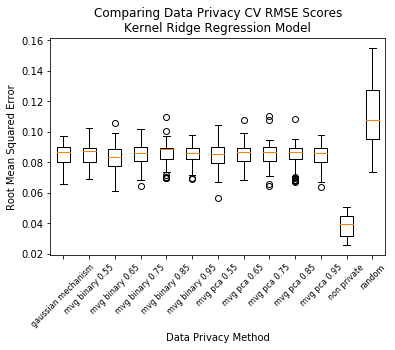

In [41]:
# Boxplot of experiment RMSE results 
boxplot_args = dict(notch=False,bootstrap=1000)

plot, boxplot = plot_boxes(
        title='Comparing Data Privacy CV RMSE Scores\nKernel Ridge Regression Model',
        xlabel='Data Privacy Method',
        ylabel='Root Mean Squared Error',
        xplot_labels=e1_rmse_labels,
        plot_data=e1_rmse_data,
        xplot_label_args=dict(rotation=45, fontsize=8),
        **boxplot_args)

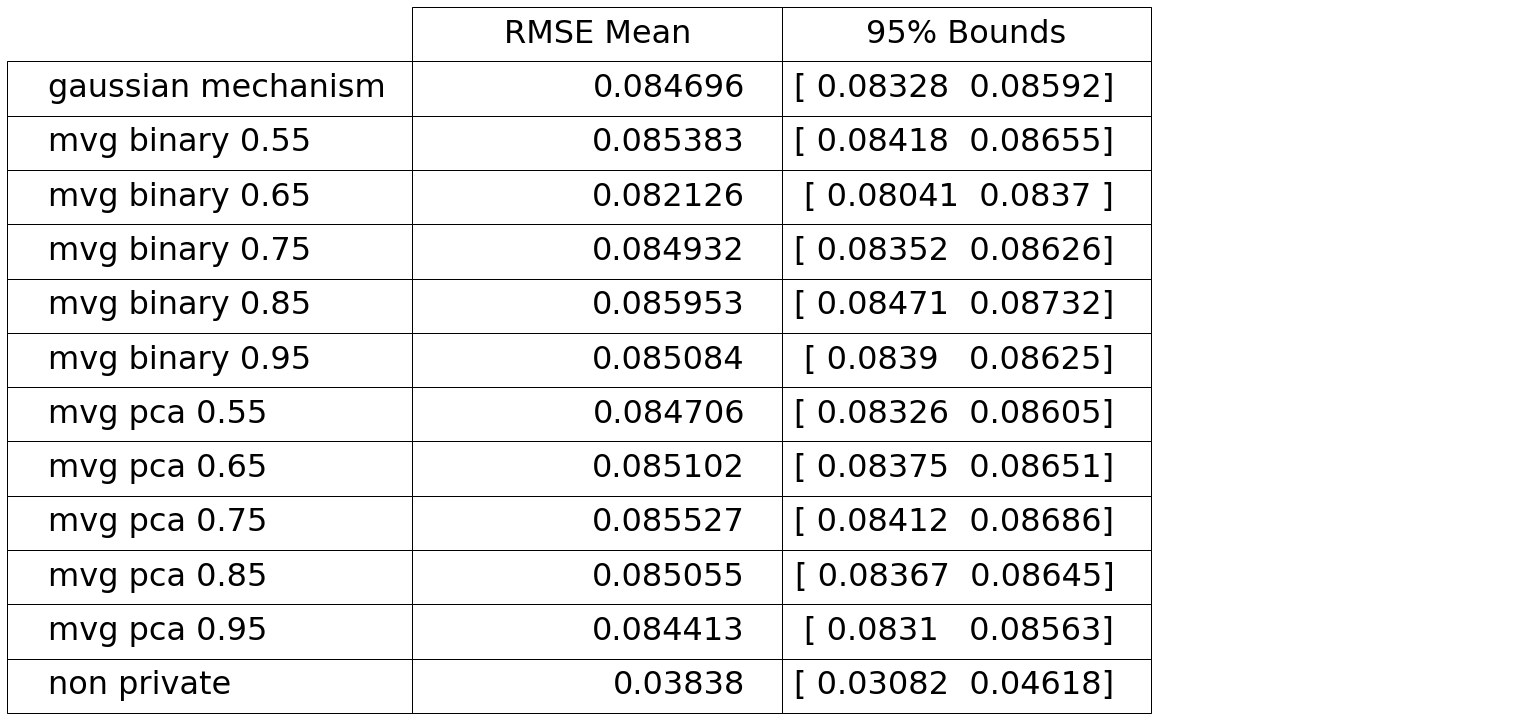

In [21]:
# Table of results
fig, ax = plot.subplots()

# fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=rmse_data_table,
                 rowLabels=e1_rmse_labels,
                 colWidths=[1]*2,
                 colLabels=['RMSE Mean', '95% Bounds'],
                 loc='left')
table.auto_set_font_size(False)
table.set_fontsize(32)
table.scale(1, 4)

fig.tight_layout()
plot.show()